# **Introduction**

In this case study, we have created models that can automatically classify customer complaints based on the products and services that the ticket mentions.

## **Understanding Problem Statement**

For a financial company, customer complaints carry a lot of importance, as they are often an indicator of the shortcomings in their products and services. If these complaints are resolved efficiently in time, they can bring down customer dissatisfaction to a minimum and retain them with stronger loyalty. This also gives them an idea of how to continuously improve their services to attract more customers.



These customer complaints are unstructured text data; so, traditionally, companies need to allocate the task of evaluating and assigning each ticket to the relevant department to multiple support employees. This becomes tedious as the company grows and has a large customer base.



In this case study, you will be working as an NLP engineer for a financial company that wants to automate its customer support tickets system. As a financial company, the firm has many products and services such as credit cards, banking and mortgages/loans.

## **Business goal**



We need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF <b> Non-Negative Matrix Factorization </b> to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.


##### **Pipelines that needs to be performed:**

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading
2. Text preprocessing
3. Exploratory data analysis (EDA)
4. Feature extraction
5. Topic modelling (NMF)
6. Model building using supervised learning
7. Model training and evaluation
8. Model inference

In [1]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings
warnings.filterwarnings('ignore')

# NLP Packages
import nltk
# nltk.download('all')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [2]:
data = json.load(open("ticket_complaints.json"))
df = pd.json_normalize(data)
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [3]:
df.shape

(78313, 22)

In [4]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [5]:
# Extracting the needed column
df = df[['_source.complaint_id', '_source.complaint_what_happened','_source.product','_source.sub_product']]

In [6]:
df.head()

,_source.complaint_id,_source.complaint_what_happened,_source.product,_source.sub_product
0,3211475,,Debt collection,Credit card debt
1,3229299,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,3199379,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,2673060,,Mortgage,Conventional home mortgage
4,3203545,,Credit card or prepaid card,General-purpose credit card or charge card


In [7]:
# Renaming the columns
df.rename(columns={
    '_source.complaint_id':'complaint_id',
    '_source.complaint_what_happened':'complaint',
    '_source.product':'category',
    '_source.sub_product':'sub_category',
}, inplace = True)

df.head()

,complaint_id,complaint,category,sub_category
0,3211475,,Debt collection,Credit card debt
1,3229299,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,3199379,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,2673060,,Mortgage,Conventional home mortgage
4,3203545,,Credit card or prepaid card,General-purpose credit card or charge card


In [8]:
df['category'] = df['category'] + '+' + df['sub_category']
df['text'] = df['complaint']
df.drop(['complaint','sub_category'],axis=1,inplace=True)
df.head()

,complaint_id,category,text
0,3211475,Debt collection+Credit card debt,
1,3229299,Debt collection+Credit card debt,Good morning my name is XXXX XXXX and I apprec...
2,3199379,Credit card or prepaid card+General-purpose cr...,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,2673060,Mortgage+Conventional home mortgage,
4,3203545,Credit card or prepaid card+General-purpose cr...,


In [9]:
# Missing Values
df.isnull().sum()

,0
complaint_id,0
category,10571
text,0


In [10]:
# Check the empty strings
print('Empty strings before filtering:', len(df[df['text'] == '']))

# retain only the data whcih is not an empty string
df = df[df['text'] != '']

# Check the empty strings
print('Empty strings after filtering:', len(df[df['text'] == '']))

# missing values
df.isnull().sum()

Empty strings before filtering: 57241
Empty strings after filtering: 0


,0
complaint_id,0
category,2109
text,0


### **Prepare the text for topic modeling**

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove stopwords and words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts

In [11]:
lemma = WordNetLemmatizer()

In [12]:
def only_alpha(text):
  review = re.sub('[^a-zA-Z]', ' ', text)
  return review

In [13]:
def remove_html(text):
  html = re.compile('<.*?>')
  return re.sub(html,'', text)

In [14]:
def remove_http(text):
  http = re.compile('http\S+')
  return re.sub(http,'', text)

In [15]:
def con_lower_pii(text):
    # remove words made entirely of x's (xx, xxx, xxxx, etc.)
    review = re.sub(r'\b[xX]{2,}\b', '', text)
    cleaned = re.sub(r'\s+', ' ', review).strip()
    return cleaned.lower()

In [16]:
def stopword_lemm(text):
  review = text.split()
  lem_stop = [lemma.lemmatize(word) for word in review if word not in list(stopwords.words('english'))]
  return ' '.join(lem_stop)

In [17]:
def extract_pos_tag(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    sent = [word for word, tag in tagged if tag.startswith('NN') or tag.startswith('VB')]
    return ' '.join(sent)

In [38]:
def text_norm(text):
  text = remove_html(text)
  text = remove_http(text)
  text = only_alpha(text)
  text = con_lower_pii(text)
  #text = extract_pos_tag(text)
  text = stopword_lemm(text)
  return text

In [39]:
df['text_norm'] = df['text'].apply(text_norm)
df.head()

,complaint_id,category,text,text_norm,topic
1,3229299,Debt collection+Credit card debt,Good morning my name is XXXX XXXX and I apprec...,good morning name appreciate could help put st...,2
2,3199379,Credit card or prepaid card+General-purpose cr...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded card told agent upgrade anniversary d...,0
10,3233499,"Credit reporting, credit repair services, or o...",Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,1
11,3180294,"Credit reporting, credit repair services, or o...","On XX/XX/2018, while trying to book a XXXX XX...",trying book ticket came across offer applied t...,1
14,3224980,Checking or savings account+Checking account,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,3


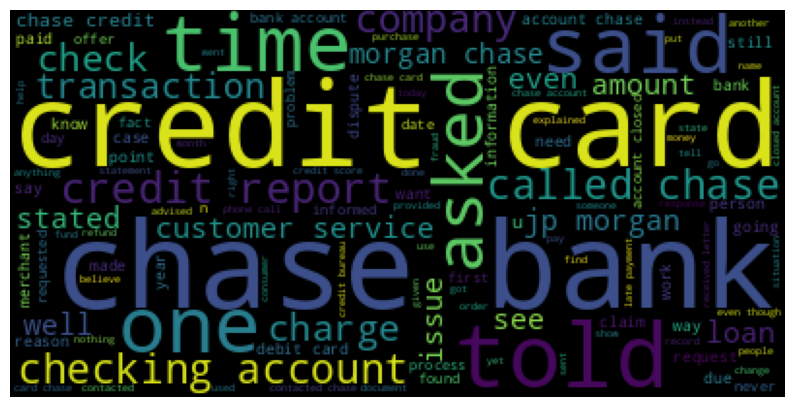

In [40]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(' '.join(df['text_norm']))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [41]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def get_top_ngrams(text, n_gram, top=None):
  vec = CountVectorizer(ngram_range=(n_gram,n_gram), stop_words='english').fit(text)
  bag_of_words = vec.transform(text)

  sum_words = bag_of_words.sum(axis=0)
  word_freq =[(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
  word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
  return word_freq[:top]

In [42]:
top_30_unigram = get_top_ngrams(df['text_norm'], n_gram=1, top=30)
top_30_bigrams = get_top_ngrams(df['text_norm'], n_gram=2, top=30)
top_30_trigrams = get_top_ngrams(df['text_norm'], n_gram=3, top=30)

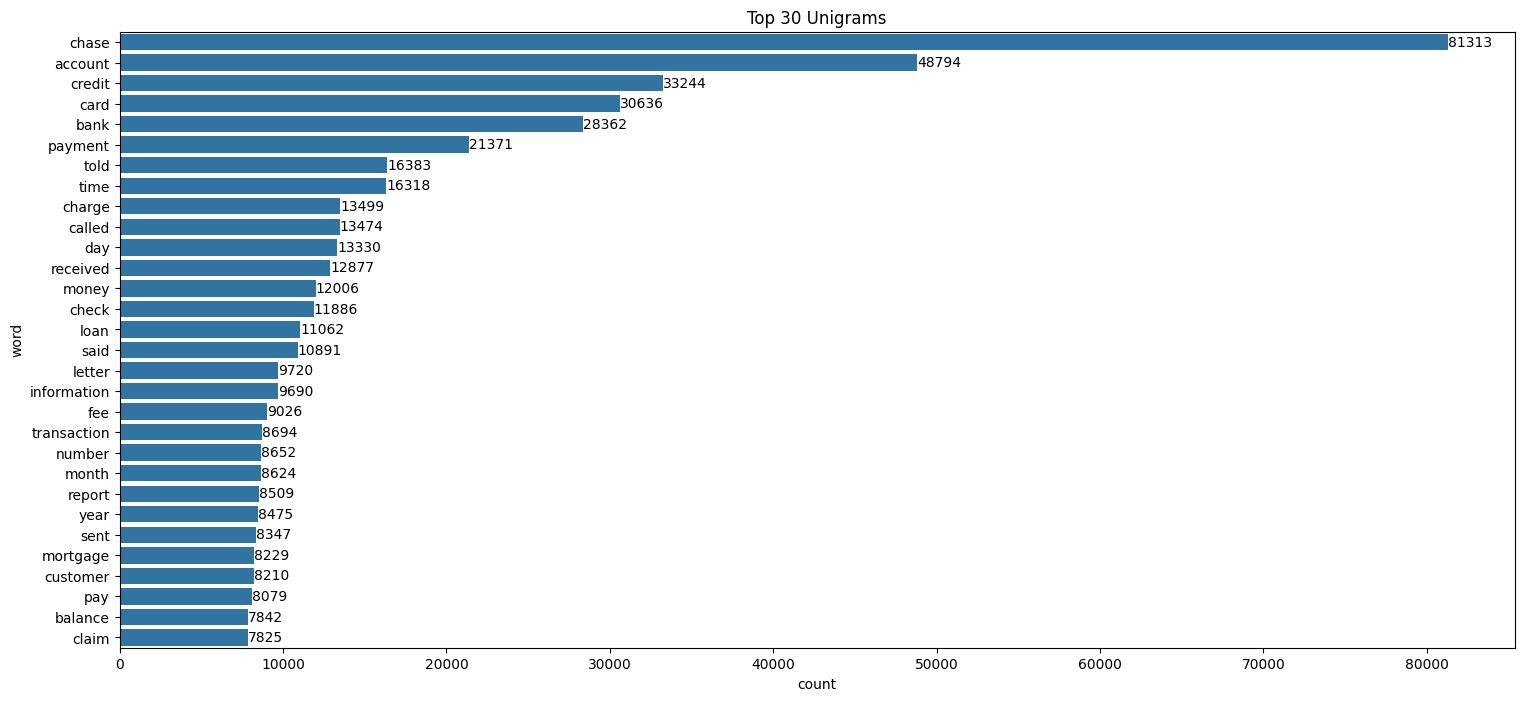

In [43]:
df1 = pd.DataFrame(top_30_unigram, columns=['word','count'])
plt.figure(figsize=(18,8))
fig = sns.barplot(y=df1['word'], x=df1['count'])
fig.bar_label(fig.containers[0])
plt.title('Top 30 Unigrams')
plt.show()

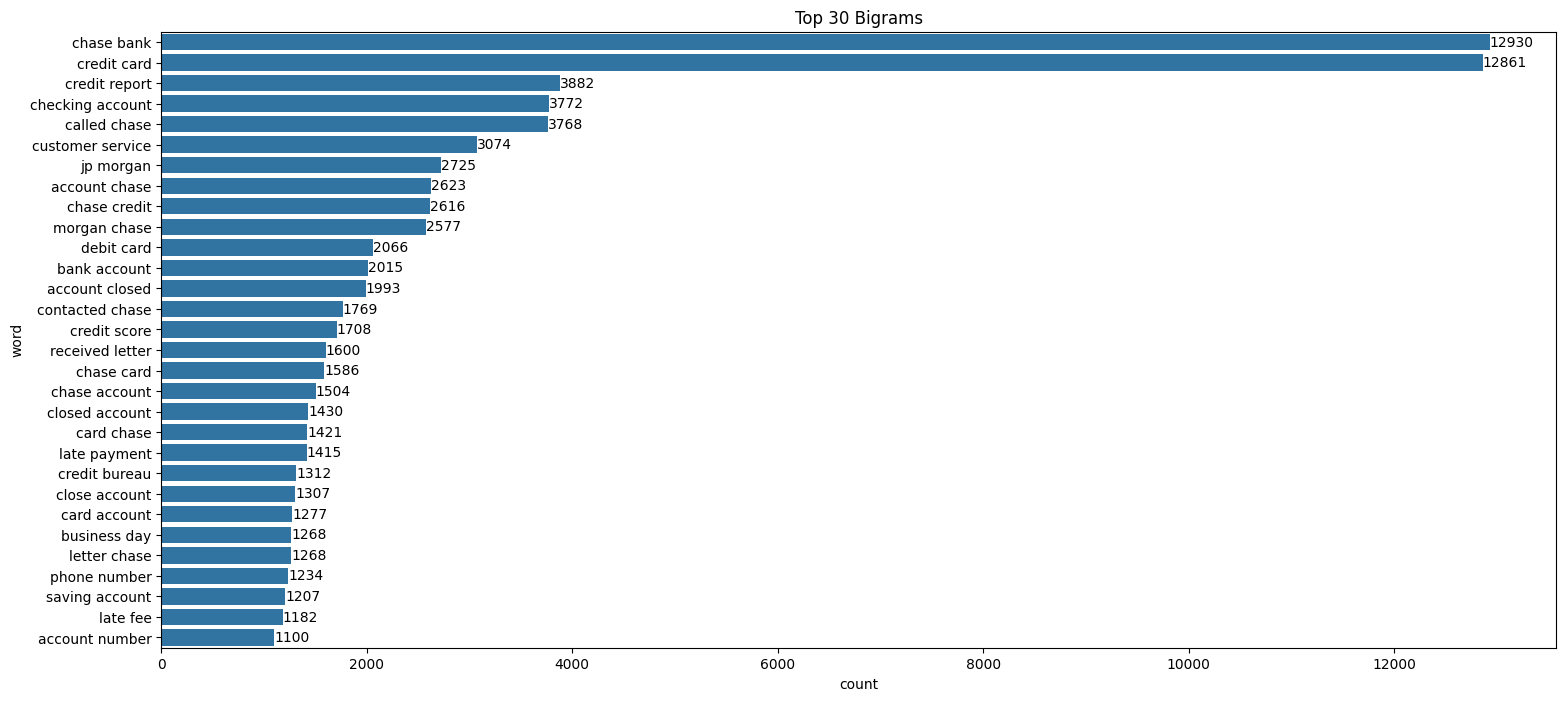

In [44]:
df1 = pd.DataFrame(top_30_bigrams, columns=['word','count'])
plt.figure(figsize=(18,8))
fig = sns.barplot(y=df1['word'], x=df1['count'])
fig.bar_label(fig.containers[0])
plt.title('Top 30 Bigrams')
plt.show()

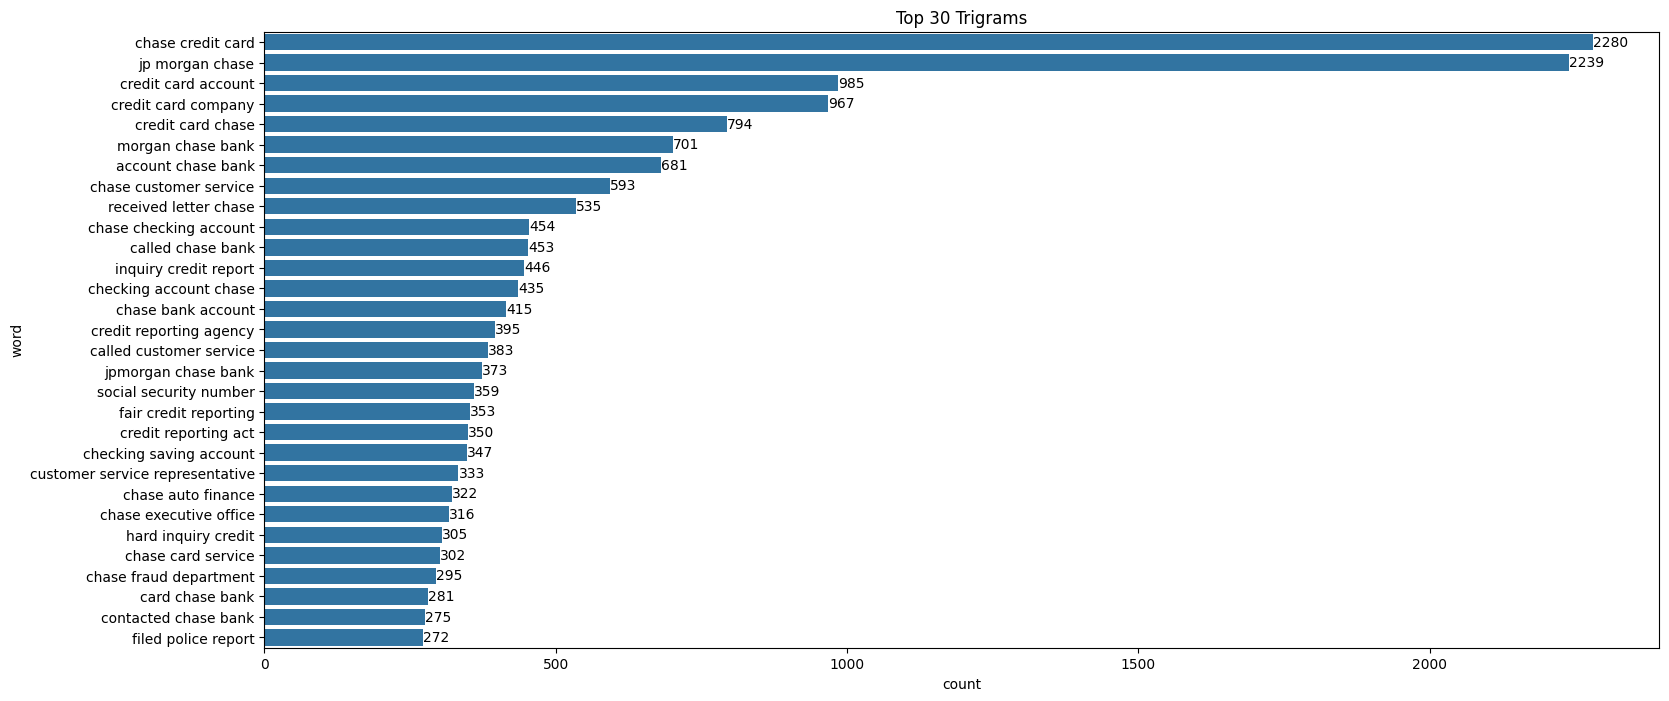

In [45]:
df1 = pd.DataFrame(top_30_trigrams, columns=['word','count'])
plt.figure(figsize=(18,8))
fig = sns.barplot(y=df1['word'], x=df1['count'])
fig.bar_label(fig.containers[0])
plt.title('Top 30 Trigrams')
plt.show()

## **Topic Modelling using NMF**

- ### **Non-Negative Matrix Factorization (NMF)**
It is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

- In this task we are performing the following:

    * Find the best number of clusters
    * Apply the best number to create word clusters
    * Inspect & validate the correlation of each cluster wrt the complaints
    * Correct the labels if needed
    * Map the clusters to topics/cluster names

In [46]:
from sklearn.decomposition import NMF

In [47]:
# covert the raw text to tfidf matrix
tfidf = TfidfVectorizer(stop_words='english',)
dtm = tfidf.fit_transform(df.text_norm)

In [48]:
pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names_out())

,aa,aaa,aaccounts,aacount,aaid,aall,aand,aaoa,aare,aarp,...,zinging,zip,zipcode,zipped,zombie,zone,zoned,zoo,zoom,zoomed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# Manual topic modelling - trail & error method

# n_components for the model is as per the business requirements of 5 groups
num_topics = 5

# nmf
nmf_model = NMF(n_components=num_topics, random_state=42)

W1 = nmf_model.fit_transform(dtm)
H1 = nmf_model.components_

In [50]:
# print the top 15 words from each component / topic for manual mapping
num_words = 15

vocab = np.array(tfidf.get_feature_names_out())

top_words = lambda t: [vocab[i] for i in np.argsort(t)][:-num_words-1:-1]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [51]:
topics


['charge card chase dispute transaction fraud claim merchant purchase called received told service refund fraudulent',
 'credit card report inquiry hard chase account reporting score bureau company removed debt limit closed',
 'loan mortgage chase home modification property year letter foreclosure rate document bank time sale house',
 'account check bank chase money fund checking closed deposit branch told day said deposited called',
 'payment late fee balance paid month pay statement day make monthly chase auto credit account']

# Manual topic mapping

- Credit card / Prepaid card - 1 (credit card report inquiry hard chase account reporting score bureau company removed debt limit closed)

- Bank account services - 3 (account check bank chase money fund checking closed deposit branch told day said deposited called)

- Theft/Dispute reporting - 0 (charge card chase dispute transaction fraud claim merchant purchase called received told service refund fraudulent)

- Mortgages/loans - 2 (loan mortgage chase home modification property year letter foreclosure rate document bank time sale house)

- Others  - 4 (payment late fee balance paid month pay statement day make monthly chase auto credit account)

In [52]:
# create the best topic for each complaint interms of integer value 0 to 4

colnames = ['Topic_' + str(i) for i in range(nmf_model.n_components_)]
docnames = ['Doc_' + str(i) for i in range(len(df.text_norm))]
df_doc_topic = pd.DataFrame(np.round(W1, 3), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,dominant_topic
Doc_0,0.007,0.011,0.030,0.023,0.004,2
Doc_1,0.009,0.006,0.003,0.007,0.002,0
Doc_2,0.011,0.040,0.001,0.000,0.000,1
Doc_3,0.019,0.046,0.021,0.020,0.000,1
Doc_4,0.001,0.000,0.004,0.071,0.000,3


In [54]:
# assign the best topic to each of the compain in topic column
df['topic'] = significant_topic

# data sample
df.head()

,complaint_id,category,text,text_norm,topic
1,3229299,Debt collection+Credit card debt,Good morning my name is XXXX XXXX and I apprec...,good morning name appreciate could help put st...,2
2,3199379,Credit card or prepaid card+General-purpose cr...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded card told agent upgrade anniversary d...,0
10,3233499,"Credit reporting, credit repair services, or o...",Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,1
11,3180294,"Credit reporting, credit repair services, or o...","On XX/XX/2018, while trying to book a XXXX XX...",trying book ticket came across offer applied t...,1
14,3224980,Checking or savings account+Checking account,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,3


In [56]:
# Manual topic mapping

# * Credit card / Prepaid card - 1
# * Bank account services - 0
# * Theft/Dispute reporting - 3
# * Mortgages/loans - 2
# * Others  - 4

topic_mapping = {
    0: 'Bank account services',
    1: 'Credit card / Prepaid card',
    2: 'Mortgages/loans',
    3: 'Theft/Dispute reporting',
    4: 'Others'
}

# create a topic name column
df['Topic_Name'] = df['topic'].map(topic_mapping)

# data sample
df.head()

,complaint_id,category,text,text_norm,topic,Topic_Name
1,3229299,Debt collection+Credit card debt,Good morning my name is XXXX XXXX and I apprec...,good morning name appreciate could help put st...,2,Mortgages/loans
2,3199379,Credit card or prepaid card+General-purpose cr...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded card told agent upgrade anniversary d...,0,Bank account services
10,3233499,"Credit reporting, credit repair services, or o...",Chase Card was reported on XX/XX/2019. However...,chase card reported however fraudulent applica...,1,Credit card / Prepaid card
11,3180294,"Credit reporting, credit repair services, or o...","On XX/XX/2018, while trying to book a XXXX XX...",trying book ticket came across offer applied t...,1,Credit card / Prepaid card
14,3224980,Checking or savings account+Checking account,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,3,Theft/Dispute reporting


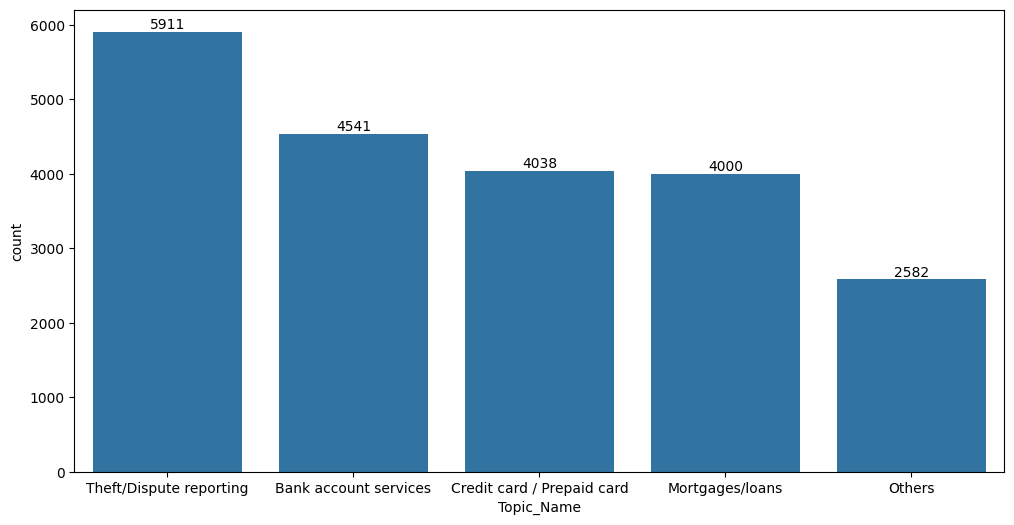

In [58]:
# Lets check if there is any class imbalance / check the target distribution

plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Topic_Name', data=df, order=df['Topic_Name'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.show()

# Preprocessing for the supervised model

In [63]:
# retain only the data that is needed for training
model_data = df[['text_norm', 'topic']]

# data sample
model_data.head()

,text_norm,topic
1,good morning name appreciate could help put st...,2
2,upgraded card told agent upgrade anniversary d...,0
10,chase card reported however fraudulent applica...,1
11,trying book ticket came across offer applied t...,1
14,grand son give check deposit chase account fun...,3


In [64]:
# train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(model_data.text_norm, model_data.topic, test_size=0.2, random_state=42, stratify=model_data.topic)

In [65]:
# vector transforming
vectorizer = TfidfVectorizer(stop_words='english')
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

In [66]:
# Importing the classification models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score

In [67]:
# function for gridsearch combination
def grid_search(model, folds, params, scoring):
    grid_search = GridSearchCV(model,
                               cv=folds,
                               param_grid=params,
                               scoring=scoring,
                               n_jobs=-1, verbose=1)
    return grid_search

# utility function to display the best score
def print_best_scores(model):
    print('Best Score: ', model.best_score_)
    print('Best Hyperparameters: ', model.best_params_)

# function for metic validation
def print_metrics(model):
    y_pred = model.predict(x_test_tfidf)
    print('Training Accuracy:', round(model.score(x_train_tfidf, y_train)*100, 2), '%')
    print('Testing Accuracy:', round(accuracy_score(y_pred, y_test)*100, 2), '%')
    cm = ConfusionMatrixDisplay.from_predictions(y_pred, y_test)
    print('Classiciation Report:\n\n', classification_report(y_pred, y_test))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Score:  0.8027533357051088
Best Hyperparameters:  {'alpha': 0.1}
Training Accuracy: 88.41 %
Testing Accuracy: 80.71 %
Classiciation Report:

               precision    recall  f1-score   support

           0       0.82      0.82      0.82       910
           1       0.76      0.81      0.79       756
           2       0.86      0.85      0.86       808
           3       0.90      0.78      0.83      1363
           4       0.56      0.77      0.65       378

    accuracy                           0.81      4215
   macro avg       0.78      0.81      0.79      4215
weighted avg       0.82      0.81      0.81      4215



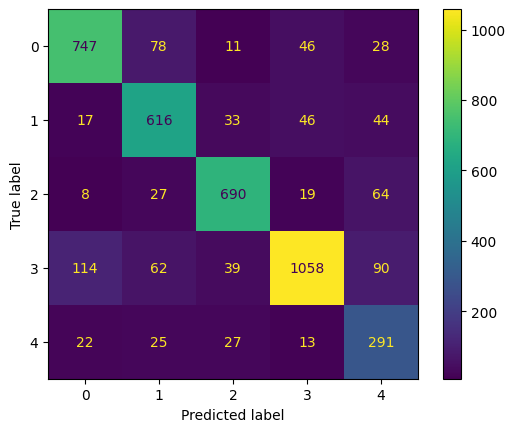

In [68]:
# Naive bayes model

mnb_model = MultinomialNB()

mnb_params = {'alpha': (1, 0.1, 0.001)}

# creating folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# create a gridsearch object
grid_search_mnb = grid_search(mnb_model, folds, mnb_params, None)

# fit model
grid_search_mnb.fit(x_train_tfidf, y_train)

# best hyper parameter and score
print_best_scores(grid_search_mnb)

# metrics
print_metrics(grid_search_mnb)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score:  0.9677879111942523
Best Hyperparameters:  {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
Training Accuracy: 100.0 %
Testing Accuracy: 97.08 %
Classiciation Report:

               precision    recall  f1-score   support

           0       0.97      0.96      0.96       921
           1       0.96      0.98      0.97       797
           2       0.97      0.98      0.97       796
           3       0.98      0.98      0.98      1181
           4       0.97      0.96      0.96       520

    accuracy                           0.97      4215
   macro avg       0.97      0.97      0.97      4215
weighted avg       0.97      0.97      0.97      4215



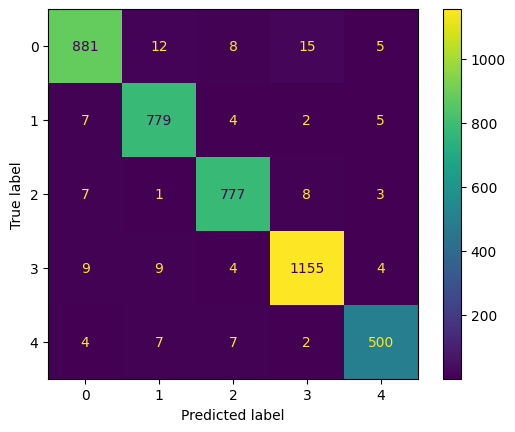

In [69]:
# logistic regression model

log_reg = LogisticRegression()

log_reg_params = {'C': [0.01, 1, 10],
                  'penalty': ['l1', 'l2'],
                  'solver': ['liblinear', 'saga', 'newton-cg']}

# creating folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# create a gridsearch object
grid_search_logreg = grid_search(log_reg, folds, log_reg_params, None)

# fit model
grid_search_logreg.fit(x_train_tfidf, y_train)

# best hyper parameter and score
print_best_scores(grid_search_logreg)

# metrics
print_metrics(grid_search_logreg)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Score:  0.8032866508806361
Best Hyperparameters:  {'max_depth': 30, 'min_samples_leaf': 8}
Training Accuracy: 89.19 %
Testing Accuracy: 81.76 %
Classiciation Report:

               precision    recall  f1-score   support

           0       0.80      0.78      0.79       935
           1       0.81      0.82      0.82       801
           2       0.83      0.84      0.83       793
           3       0.84      0.85      0.85      1167
           4       0.77      0.77      0.77       519

    accuracy                           0.82      4215
   macro avg       0.81      0.81      0.81      4215
weighted avg       0.82      0.82      0.82      4215



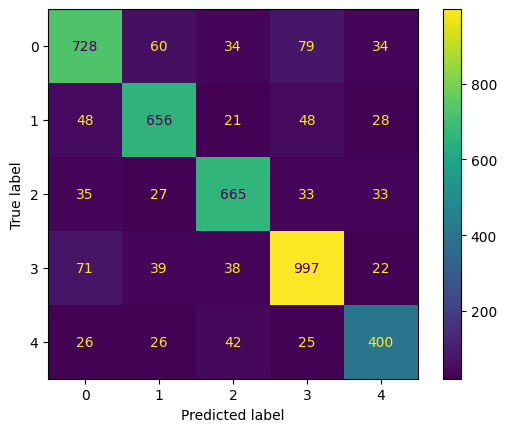

In [70]:
# Decision Tree model

tree_model = DecisionTreeClassifier()

tree_params = {'max_depth': [5, 10, 20, 30],
               'min_samples_leaf': [2, 4, 6, 8]}

# creating folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# create a gridsearch object
grid_search_tree = grid_search(tree_model, folds, tree_params, None)

# fit model
grid_search_tree.fit(x_train_tfidf, y_train)

# best hyper parameter and score
print_best_scores(grid_search_tree)

# metrics
print_metrics(grid_search_tree)

Training Accuracy: 100.0 %
Testing Accuracy: 97.01 %
Classiciation Report:

               precision    recall  f1-score   support

           0       0.97      0.95      0.96       922
           1       0.96      0.98      0.97       796
           2       0.97      0.98      0.97       797
           3       0.98      0.98      0.98      1181
           4       0.97      0.96      0.96       519

    accuracy                           0.97      4215
   macro avg       0.97      0.97      0.97      4215
weighted avg       0.97      0.97      0.97      4215



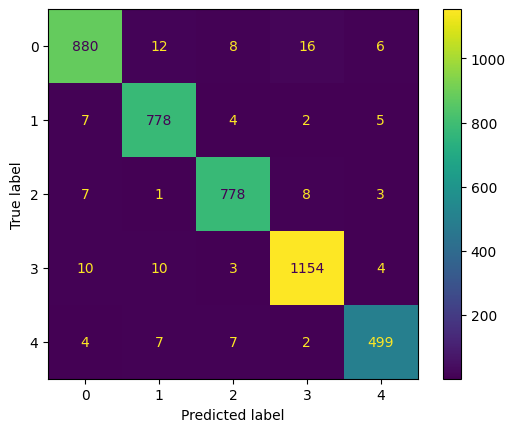

In [71]:
# Final model - Logistic Regression

# building the final model
final_model = LogisticRegression(C= 10, penalty= 'l1', solver= 'saga')
final_model.fit(x_train_tfidf, y_train)

# final metrics
print_metrics(final_model)

In [72]:
# Predict the incoming complaint

def predict_ticket_class():
    # user input
    cmnt = input('Enter your ticket compaint: ')
    # convert input to series
    input_cmnt = pd.Series(cmnt.split(','))
    # preprocessing
    input_cmnt = input_cmnt.apply(text_norm)
    # vector transforming
    input_cmnt_tfidf = vectorizer.transform(input_cmnt)
    # prediction
    output = final_model.predict(input_cmnt_tfidf)
    # topic mapping
    topic_mapping = {
        0: 'Bank account services',
        1: 'Credit card / Prepaid card',
        2: 'Mortgages/loans',
        3: 'Theft/Dispute reporting',
        4: 'Others'}
    # print the output
    print('\nThis ticket is mapped under:', topic_mapping[output[0]])

In [73]:
# Prediction
predict_ticket_class()

Enter your ticket compaint: I want to extend my loan tenure after the intereset rate cut and repo rate change

This ticket is mapped under: Mortgages/loans


In [76]:
predict_ticket_class()

Enter your ticket compaint: I am confused about the banking products and services for me. I need a representative to explain it to me

This ticket is mapped under: Bank account services


In [77]:
predict_ticket_class()

Enter your ticket compaint: I afraid my account is hacked and I just noticed it today after a unauthorized trasactions. please block it

This ticket is mapped under: Theft/Dispute reporting
